diffusion_02.ipynb
# Denoising Diffusion probabilistic models (DDPM)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style

device = 'mps'
hdr_plot_style()

In [3]:
def sample_batch(size, noise=0.5):
    x, _ = make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

In [4]:
data = sample_batch(10 ** 4).T

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sliced Score Matching
# Jacobian vector product trick
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)

    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)

    # Compute the optimized vector-product jacobian
    logp, jvp = torch.autograd.functional.jvp(model, samples, vectors, create_graph=True)

    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.

    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

In [6]:
def denoising_score_mathcing(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = -1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    
    loss = 1 / 2 * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

In [7]:
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()

In [8]:
def train():
    for t in range(5000):
        print(f'\r{t}/5000', end='   ')
        loss = denoising_score_mathcing(model, dataset)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not t % 1000: print(loss)

# train()    

In [9]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach().cpu()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

    plt.figure(figsize=(16, 12))
    if plot_scatter:
        plt.scatter(*data, alpha=0.3, color='red', edgecolors='white', s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)

# plot_gradients(model, data)

In [10]:
def sample_langevin(model, x, n_steps=10, eps=1e-3, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for _ in range(n_steps):
        z_t = torch.randn(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

In [11]:
def plot_langevin(x=None):
    if x is None:
        x = torch.Tensor([1.5, -1.5])
    samples = sample_langevin(model, x).detach()

    plot_gradients(model, data)
    plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolors='white', s=150)
    deltas = (samples[1:] - samples[:-1])
    deltas = deltas - deltas / torch.tensor(np.linalg.norm(deltas, keepdims=True, axis=-1)) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(samples[i, 0], samples[i, 1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color='green', linewidth=3)

## Diffusion Models

### Forward Process

In [12]:
def make_beta_schedule(schedule='linear', n_time_steps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_time_steps)
    elif schedule == 'quad':
        betas = torch.linspace(start ** .5, end ** .5, n_time_steps) ** 2
    elif schedule == 'sigmoid':
        betas = torch.linspace(-6, 6, n_time_steps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [13]:
# diffusion parameters
n_steps = 100
betas = make_beta_schedule(schedule='sigmoid', n_time_steps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [14]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t)
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    out = out.reshape(*reshape)
    return out

def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return alphas_t * x_0 + alphas_1_m_t * noise

def plot_diffusion():
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    for t in range(10):
        q_i = q_sample(dataset, torch.tensor([t * 10]))
        axs[t].scatter(q_i[:, 0], q_i[:, 1], s=10)
        axs[t].set_axis_off()
        axs[t].set_title('$q(\mathbf{x}_{'+str(t*10)+'})')

def q_sample_loop_var():
    for t in range(33):
        q_t = q_sample(dataset, torch.tensor([t*3]))
        print(t, q_t.var())

q_sample_loop_var()

0 tensor(0.4705)
1 tensor(0.4703)
2 tensor(0.4705)
3 tensor(0.4711)
4 tensor(0.4713)
5 tensor(0.4707)
6 tensor(0.4714)
7 tensor(0.4716)
8 tensor(0.4733)
9 tensor(0.4731)
10 tensor(0.4741)
11 tensor(0.4751)
12 tensor(0.4794)
13 tensor(0.4827)
14 tensor(0.4850)
15 tensor(0.4921)
16 tensor(0.4988)
17 tensor(0.5071)
18 tensor(0.5145)
19 tensor(0.5292)
20 tensor(0.5305)
21 tensor(0.5451)
22 tensor(0.5611)
23 tensor(0.5666)
24 tensor(0.5825)
25 tensor(0.5937)
26 tensor(0.6101)
27 tensor(0.6180)
28 tensor(0.6282)
29 tensor(0.6417)
30 tensor(0.6467)
31 tensor(0.6603)
32 tensor(0.6721)


### Posterior $q(x_{t-1} | x_t, x_0)$

$$q(x_{t-1} | x_t, x_0) = \mathcal N (x_{t-1} ; \tilde \mu_t(x_t, x_0), \tilde \beta_t \mathbf I)$$

여기서 $\tilde \mu$와 $\tilde \beta$는 closed form으로 얻을 수 있다.

$$\text{where} \quad \tilde\mu_t(x_t, x_0) := \frac {\sqrt{\tilde\alpha_{t-1}}\beta_t}{1 - \tilde\alpha_t}x_0 + \frac {\sqrt\alpha_t(1 - \tilde\alpha_{t-1})} {1 - \tilde\alpha_t}x_t\\
\text{and} \quad \tilde\beta_t := \frac {1 - \tilde \alpha_{t-1}} 
{1 - \tilde\alpha_t} \beta_t
$$

유도는 따로 하지 않는걸로.. 귀찮

In [32]:
# posterior q(x_{t-1} | x_t, x_0) parameters
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1,1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

In [33]:
def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0) # t = 0 일때 log var not defined
    return mean, var

### Reverse process

In [59]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x_t, t):
        x = F.softplus(self.lin1(x_t, t))
        x = F.softplus(self.lin2(x, t))
        return self.lin3(x)

In [60]:
def p_mean_variance(model, x, t):
    out = model(x, t)
    mean, log_var = torch.split(out, 2, dim=-1)
    return mean, log_var

def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample)

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for t in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, t)
        x_seq.append(cur_x)
    return x_seq

In [61]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

In [73]:
# Training loss from "Sohl-Dickstein, Deep unsupervised learning using nonequilibrium thermodynamics."
def compute_loss(true_mean, true_var, model_mean, model_var):
    # DKL(q(x_{t-1} | x_t, x_0) || p_\theta(x_{t-1} | x_t))
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    print('KL: ',KL.shape)
    
    # H(X_0)
    H_start = entropy(betas[0].float()).float()
    print('H_start: ', H_start)

    # Constant 
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    print('beta_full_trajectory: ',beta_full_trajectory)
    
    H_end = entropy(beta_full_trajectory.float()).float()
    print('H_end: ',H_end)
    
    H_prior = entropy(torch.tensor([1.])).float()
    print('H_prior: ',H_prior)

    negL_bound = KL * n_steps + H_start - H_end + H_prior
    print(f'negL_bound = {KL[0]} * {n_steps} + {H_start} - {H_end} + {H_prior} = {negL_bound[0]}')

    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss
    
    L_diff_bits = negL_diff / np.log(2.)
    
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

In [74]:
def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]

    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    
    # Antithetic sampling
    t = torch.cat([t, n_steps - t -1], dim=0)[:batch_size].long()

    # Perform diffuion for step t
    x_t = q_sample(x_0, t)

    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)

    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)

    # Compute the loss
    loss = compute_loss(true_mean, true_var, model_mean, model_var)

    return loss
    

In [75]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
batch_size = 128

permutation = torch.randperm(dataset.size()[0])

indices = permutation[:batch_size]
batch_x = dataset[indices]

loss = loss_likelihood_bound(model, batch_x)

KL:  torch.Size([128, 2])
H_start:  tensor(-3.7154)
beta_full_trajectory:  tensor(0.3950)
H_end:  tensor(0.9546)
H_prior:  tensor([1.4189])
negL_bound = tensor([3.3733, 3.0058], grad_fn=<SelectBackward0>) * 100 + -3.7154250144958496 - 0.9545619487762451 + tensor([1.4189]) = tensor([334.0759, 297.3264], grad_fn=<SelectBackward0>)


# Denoising Diffusion Probabilistic Models(DDPM)

In [225]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128 ,2)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x,y))
        x = F.softplus(self.lin2(x,y))
        x = F.softplus(self.lin3(x,y))
        return self.lin4(x)

def p_sample(model, x, t):
    # timestep t
    t = torch.tensor([t])

    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))

    # model output
    eps_theta = model(x, t)

    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))

    # Generate z
    z = torch.randn_like(x)

    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return sample

## DDPM Loss


In [226]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    '''
    이게 뭐하는건가 했는데, [-1, 1]까지 normalize 되어있는 확률변수 x에 대해서, 이게 사실 discrete한 noraml distribution [0,255]를
    원래 따랐다고 가정하고, 그때 log likelihood를 계산한다.
    p(x = c_i) c_i \in {0,1,...,255}를 cdf를 사용해서 mass를 근사한다.
    log_scales = 0.5 * log(sigma^2) = log(sigma)
    '''
    centered_x = x - means

    # 1 / sigma
    inv_stdv = torch.exp(-log_scales)  

    plus_in = inv_stdv * (centered_x + 1. / 255.)
    min_in = inv_stdv * (centered_x - 1. / 255.)

    cdf_plus = approx_standard_normal_cdf(plus_in)
    cdf_min = approx_standard_normal_cdf(min_in)
    
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    
    # -0.999, 0.999 보다 크거나 작으면 [-inf, -0.999], [0.999, inf의] mass를 사용
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

In [227]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()

    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    
    # q(x_t-1 | x_t, x_0)
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)

    # p(x_t-1 | x_t) ~ N(mu_theta(x_t, t), sigma_theta(x_t, t))
    model_mean, model_var = p_mean_variance(model, x_t, t)

    # Compute KL Loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)

    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)

    # At the first timestep return the decoder nll, otherwise return KL(q(x_{t-1} | x_t, x_0) || p(x_{t-1} | x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)
    

In [228]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]

    # select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps -t - 1], dim=0)[:batch_size].long()

    a = extract(alphas_bar_sqrt, t, x_0)

    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)

    x = x_0 * a + e * am1
    output = model(x,t)
    return (e - output).square().mean()

### Stabilizing training with Exponential Moving Average (EMA)

This idea is found in most of the implementations, which allows to implement a form of model momentum. Instead of directly updating
the weights of the model, we keep a copy of the previous values of the weights, and then update a weighted mean between the previous
and new version of the weights.

Here, we reuse the implementation proposed im DDIM repository

In [229]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data
    
    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)
            
    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow
    
    def load_state_dict(self, state_dict):
        self.shadow = state_dict

0.9984  tensor(0.9055, grad_fn=<MeanBackward0>)
100.9984  tensor(0.8131, grad_fn=<MeanBackward0>)
200.9984  tensor(0.7741, grad_fn=<MeanBackward0>)
300.9984  tensor(0.6212, grad_fn=<MeanBackward0>)
400.9984  tensor(0.6160, grad_fn=<MeanBackward0>)
500.9984  tensor(0.6917, grad_fn=<MeanBackward0>)
600.9984  tensor(0.6682, grad_fn=<MeanBackward0>)
700.9984  tensor(0.6007, grad_fn=<MeanBackward0>)
800.9984  tensor(0.5863, grad_fn=<MeanBackward0>)
900.9984  tensor(0.5646, grad_fn=<MeanBackward0>)
999.9984  

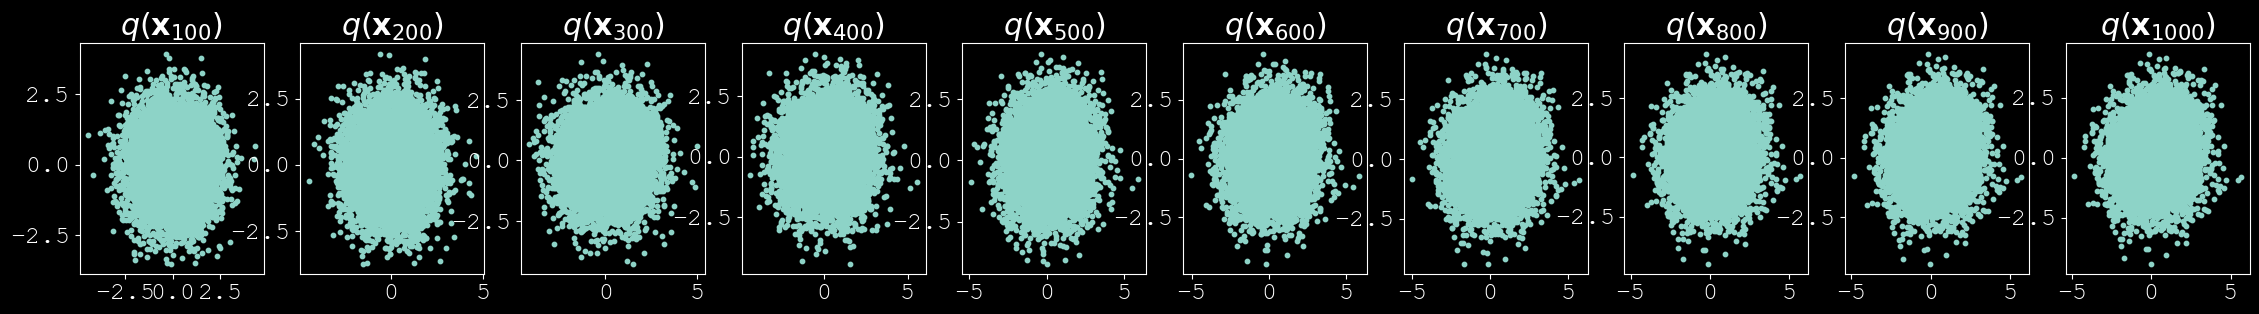

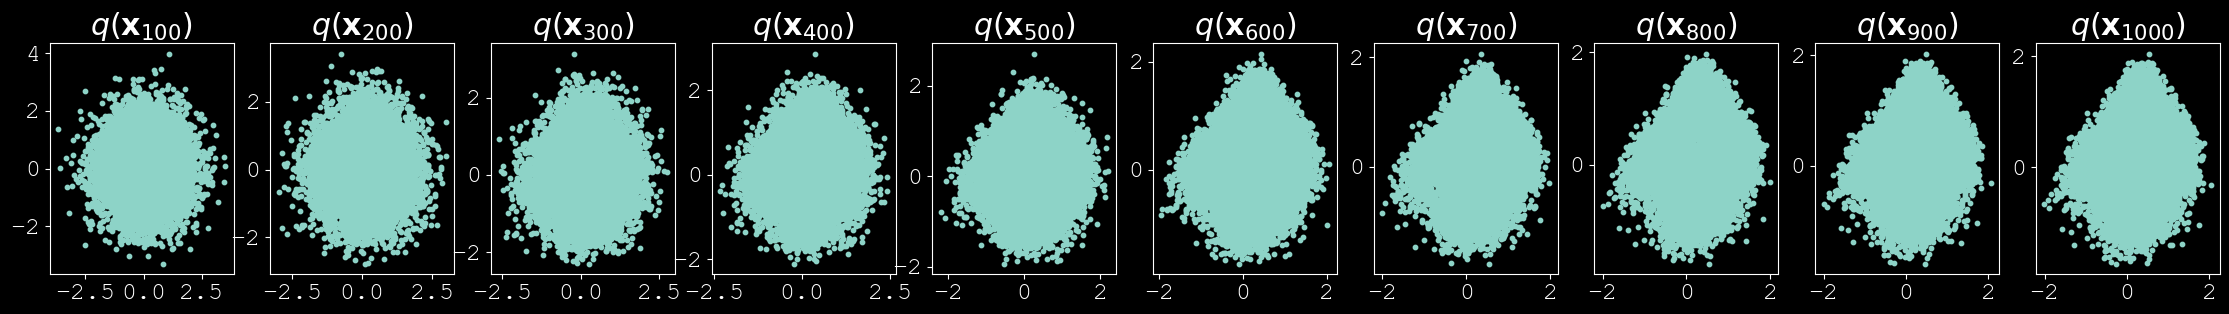

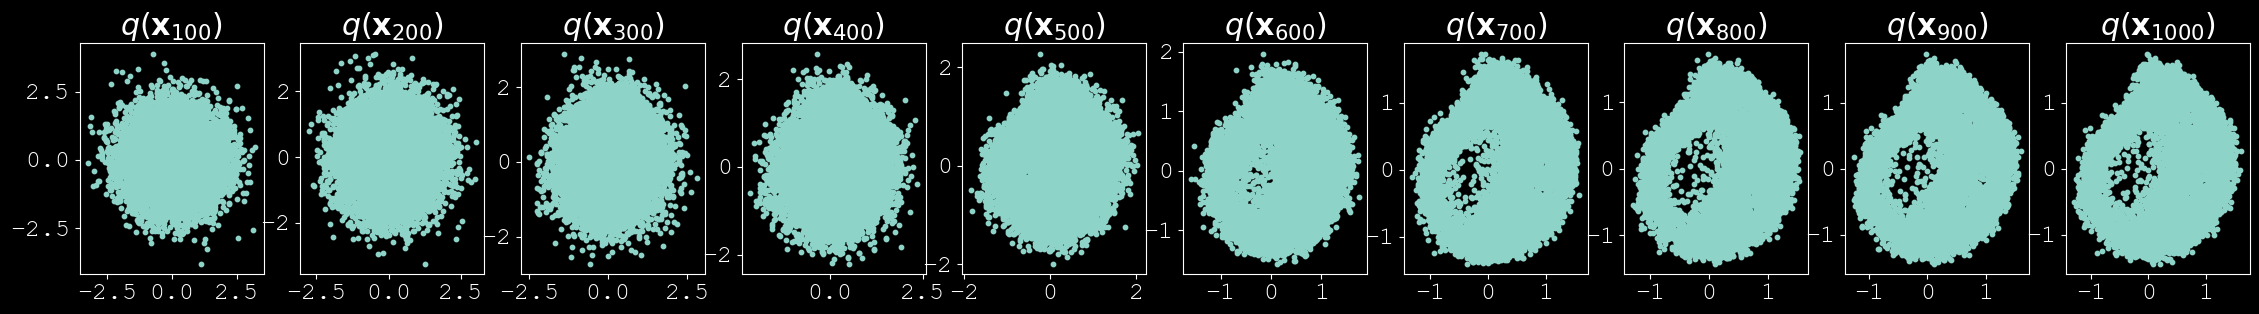

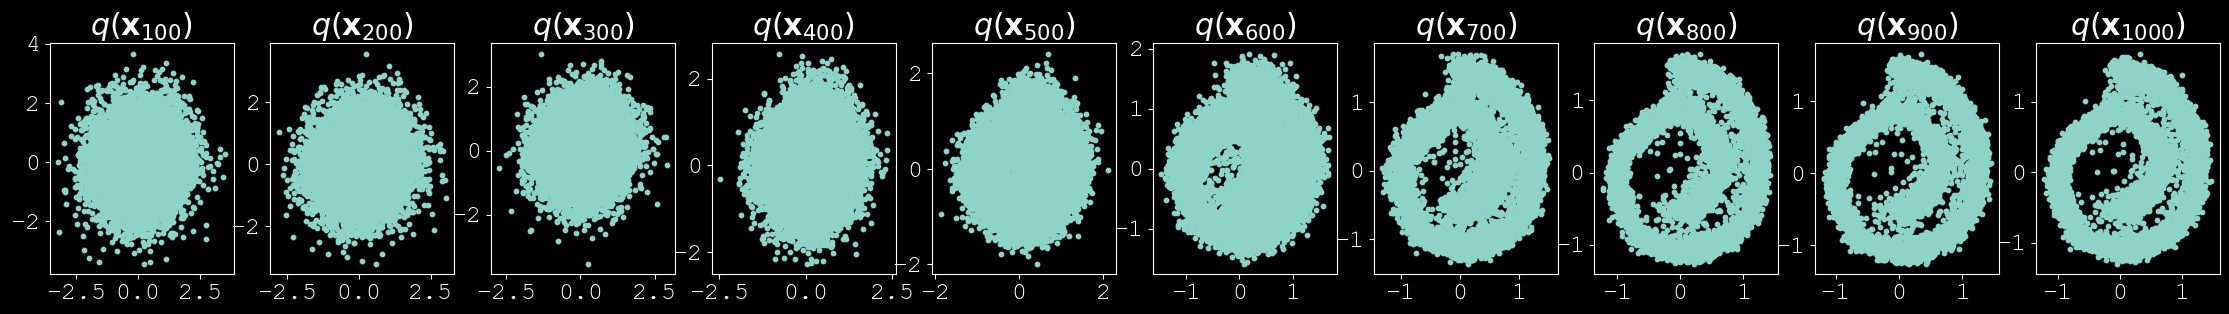

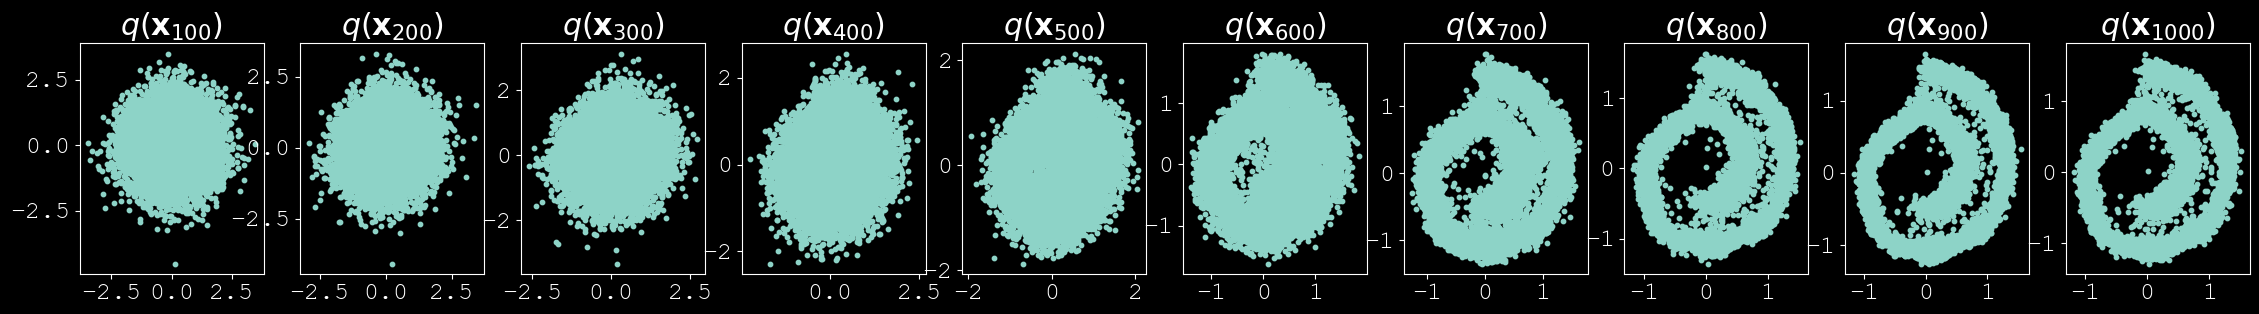

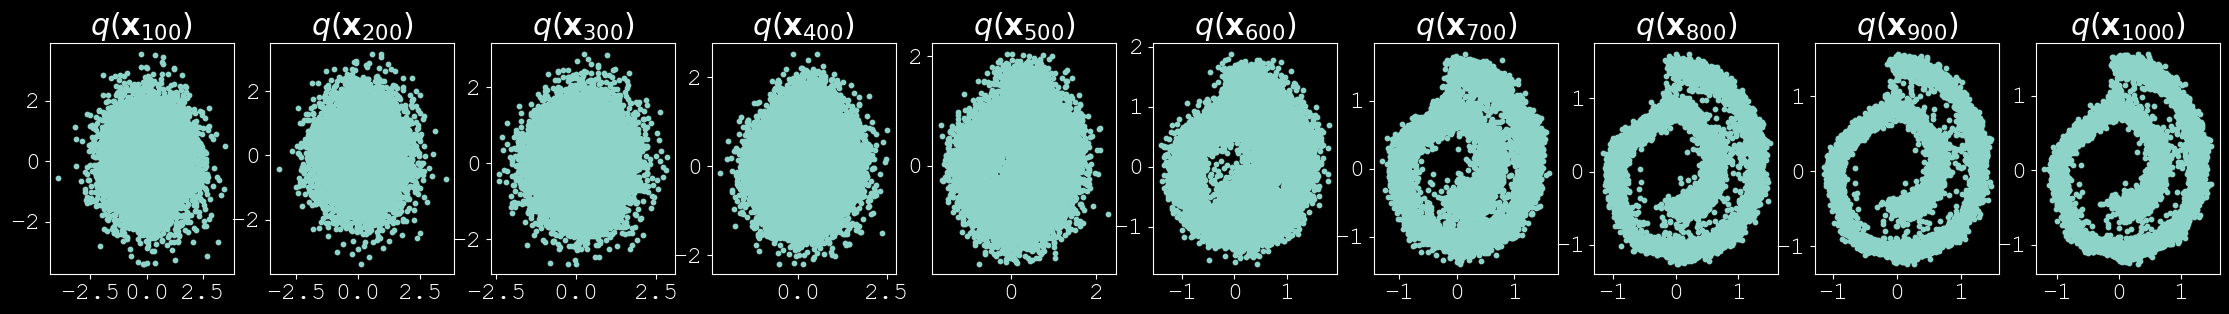

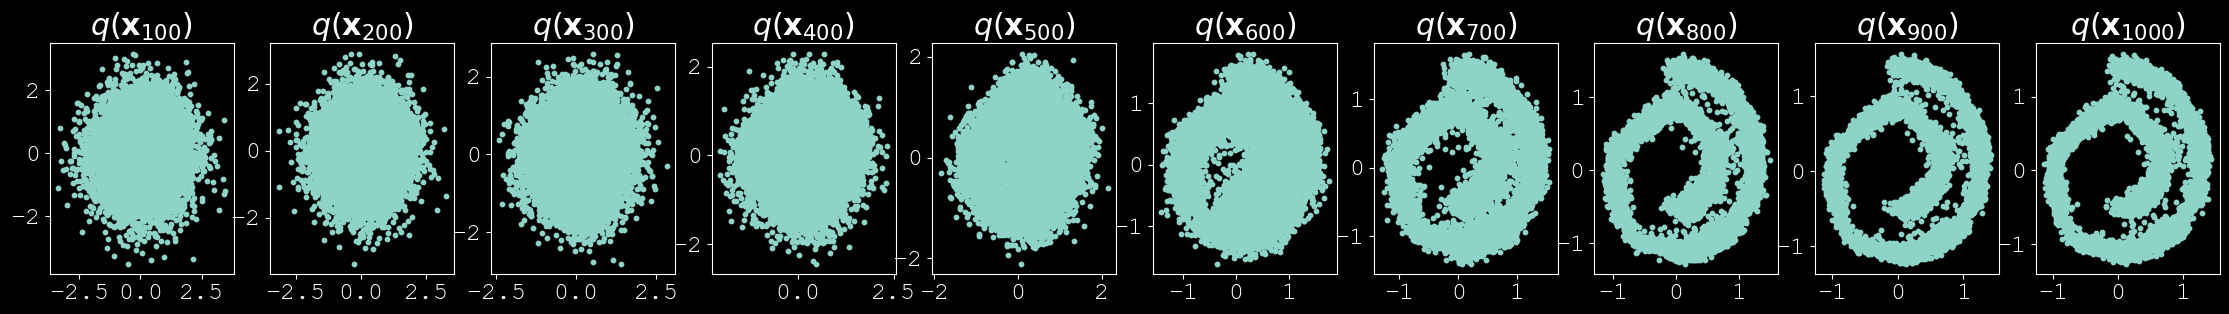

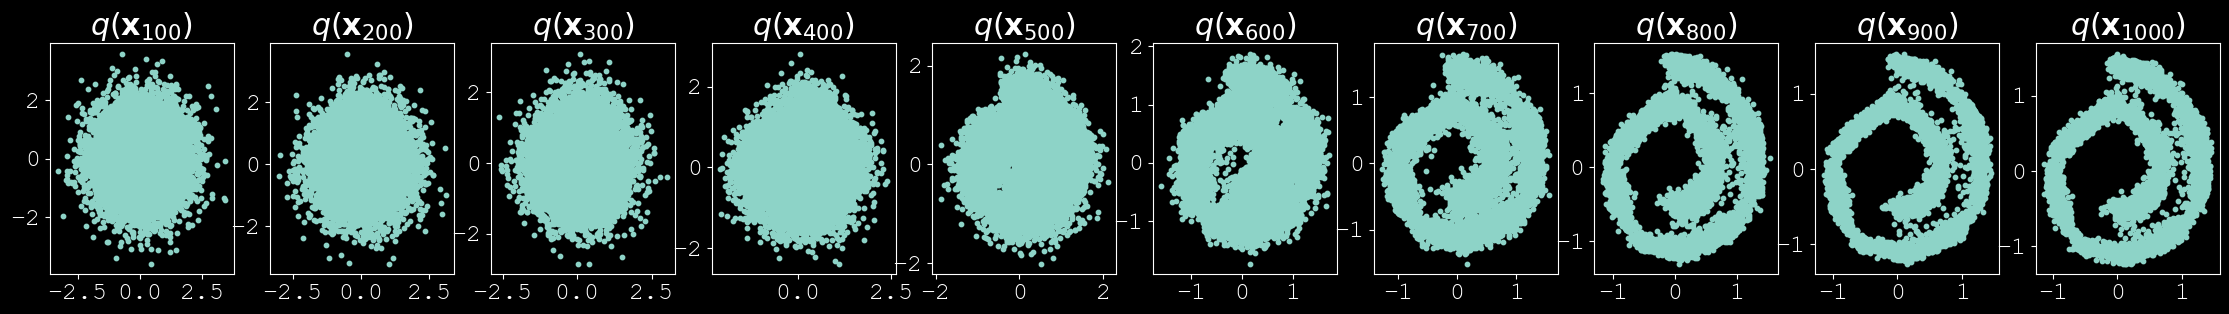

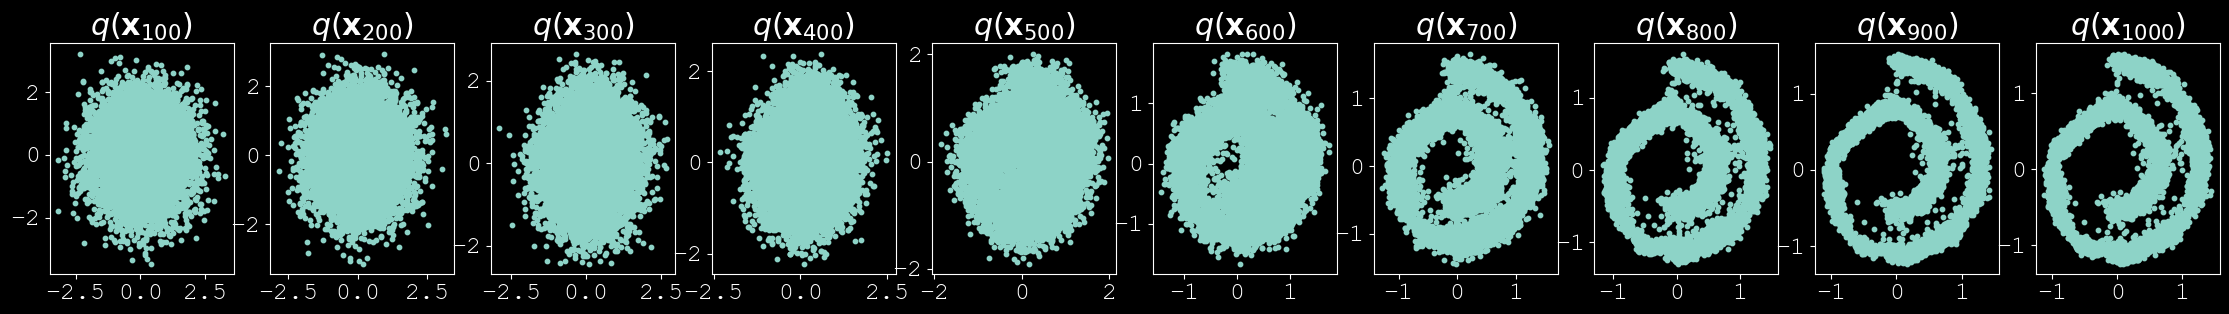

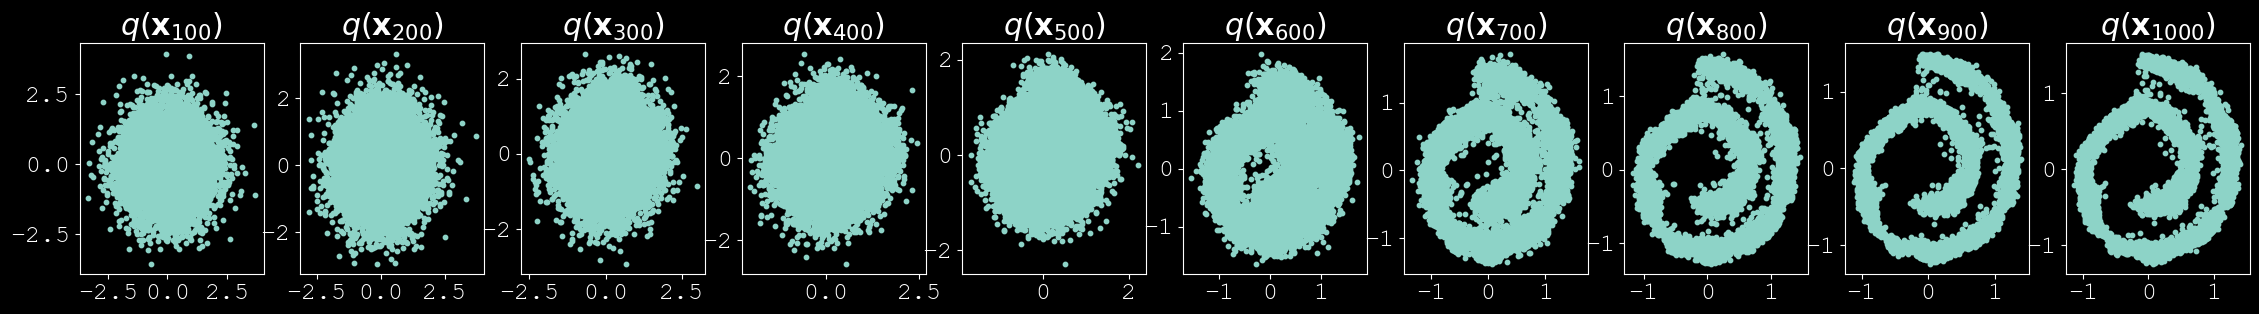

In [230]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()

ema = EMA(0.9)
ema.register(model)

batch_size = 128
for t in range(1000):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        print(f'\r{t}.{i}', end='  ')
        indices = permutation[i:i+batch_size]
        batch_size_x  = dataset[indices]

        loss = noise_estimation_loss(model, batch_x)
        optimizer.zero_grad()
        loss.backward()

        # Perfrom gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)

        optimizer.step()
        ema.update(model)
    
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')
